### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

print("Everything imported succesfully !")

Everything imported succesfully !


In [2]:
# Let's load the data and explore it
df = pd.read_csv('data.csv')

### Exploratory data analysis ( Part 1 )

In [3]:
# Let's check the shape of the dataset
print("Shape of the dataframe : ",df.shape)

Shape of the dataframe :  (7927, 16)


In [4]:
# Let's check any 4 random rows from the dataset
df.sample(4)

,job_ID,job,location,company_id,company_name,work_type,full_time_remote,no_of_employ,no_of_application,posted_day_ago,alumni,Hiring_person,linkedin_followers,hiring_person_link,job_details,Column1
2177,2662411191,Financial Analyst,"Chennai, Tamil Nadu, India",NaN,"CHANDRAMOULI AND ASSOCIATES LLP, Chartered Acc...",On-site,Full-time,NaN,55,1 day,NaN,CHANDRAMOULI PANCHAPAKESAN,NaN,https://www.linkedin.com/in/chandramouli-panch...,About the job The ideal candidate will be resp...,NaN
873,3467811044,Salesforce Developer,"Hyderabad, Telangana, India",NaN,Hirextra -World's First Staffing Aggregator,Hybrid,Full-time · Mid-Senior level,201-500 employees · Staffing and Recruiting,22,8 hours,1 company alumni,Sushmitha G,NaN,https://www.linkedin.com/in/sushmitha-g-879523206,About the job Role: Salesforce DeveloperLocati...,NaN
6562,3472811265,Business Development Manager,"New Delhi, Delhi, India",NaN,My First Boss,On-site,Full-time,11-50 employees,19,2 days,NaN,NaN,993 followers,NaN,About the job Job Title : Business Development...,NaN
724,3467806241,Lead Business Analyst,"Mumbai, Maharashtra, India",NaN,Reputed Chemical manufacturing company,On-site,Full-time · Mid-Senior level,NaN,hours,7 hours,NaN,Priya Narvekar,NaN,https://www.linkedin.com/in/priya-narvekar-180...,About the job We are hiring Lead Business Tran...,NaN


**Observation**

Out of all the features job_id,company_id,hiring_person_link,hiring_person and Column1 features are unnecessary, so we will simply remove them

In [5]:
# Removing unnecessary columns from dataset
df.drop(['Column1','job_ID','company_id','hiring_person_link','Hiring_person'],axis = 1,inplace=True)

In [6]:
# Let's get some more basic infomraiton about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7927 entries, 0 to 7926
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   job                 7894 non-null   object
 1   location            7894 non-null   object
 2   company_name        7892 non-null   object
 3   work_type           7736 non-null   object
 4   full_time_remote    7848 non-null   object
 5   no_of_employ        7603 non-null   object
 6   no_of_application   7887 non-null   object
 7   posted_day_ago      7920 non-null   object
 8   alumni              4858 non-null   object
 9   linkedin_followers  4814 non-null   object
 10  job_details         7881 non-null   object
dtypes: object(11)
memory usage: 681.4+ KB


In [7]:
# Checking if there are any duplicated values
print("Duplicate values : ",df.duplicated().sum())

Duplicate values :  122


job                    0.416299
location               0.416299
company_name           0.441529
work_type              2.409487
full_time_remote       0.996594
no_of_employ           4.087297
no_of_application      0.504605
posted_day_ago         0.088306
alumni                38.715782
linkedin_followers    39.270846
job_details            0.580295
dtype: float64


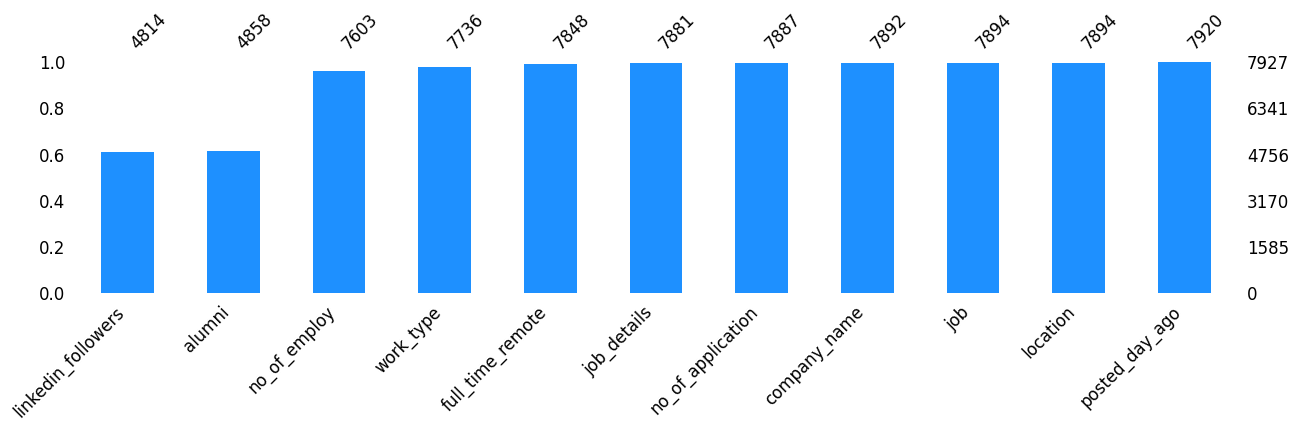

In [8]:
print(df.isnull().mean()*100)

# Visualize missing values using a bar chart
msno.bar(df,figsize = (15,3),color="dodgerblue", sort="ascending", fontsize=12)
plt.show()

In [9]:
df['work_type'].value_counts()

On-site    3258
Remote     2999
Hybrid     1479
Name: work_type, dtype: int64

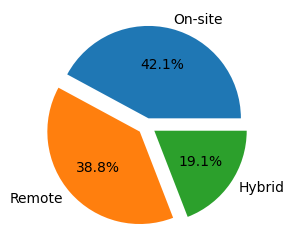

In [10]:
plt.figure(figsize=(3, 3))
ex = [0.08,0.1,0.1]
plt.pie(df['work_type'].value_counts(),labels = df['work_type'].value_counts().index,explode = ex,autopct='%1.1f%%')
plt.show()

### Data processing and feature engineering

In [11]:
# Function to extract the followers count from 'linkedin_followers' column
followers_count = []
df['linkedin_followers'] = df['linkedin_followers'].astype('object')
for i in range(len(df['linkedin_followers'])):
    row = df['linkedin_followers'].iloc[i]
    if pd.isnull(row):
        followers_count.append(np.nan)
    elif 'followers' not in row:
        followers_count.append(np.nan)
    else:
        followers = row.split(' ')[0]
        followers = followers.replace(',', '')
        followers = int(followers)
        followers_count.append(followers)

df.drop(['linkedin_followers'],axis=1,inplace=True)
df['followers_count_HM'] = pd.Series(followers_count)

In [15]:
# Replace 'hours', 'minutes', and 'seconds' with NaN
df['no_of_application'].replace(['hours', 'minute', 'seconds','minutes','hour'], np.nan, inplace=True)

In [26]:
df['posted_day_ago']

0          8 hours
1          8 hours
2          9 hours
3          7 hours
4       26 minutes
           ...    
7922        2 days
7923        2 days
7924        6 days
7925         1 day
7926        1 week
Name: posted_day_ago, Length: 7927, dtype: object

In [82]:
Alumni_count = []
for i in range(len(df)):
    item = df['alumni'].iloc[i]
    if isinstance(item, int):
        Alumni_count.append(item)
    elif isinstance(item, int):
        Alumni_count.append(np.nan)
    elif isinstance(item, str):
        item = item.split(' ')[0]
        item = item.replace(',', '')
        Alumni_count.append(int(item))   

df.drop(['alumni'],axis=1,inplace=True)
df['Alumni_count'] = pd.Series(Alumni_count)

In [68]:
for i in range(len(df)):
    item = df['alumni'].iloc[i]
    if type(item) == 'int':
        print(item)

In [77]:
for i in range(len(df)):
    item = df['alumni'].iloc[i]
    if isinstance(item, int):
        print(item)

12
12
3
1
132
12
1
4
3
5
105
5
2
1
3


In [25]:
df.head(3)

,job,location,company_name,work_type,full_time_remote,no_of_employ,no_of_application,posted_day_ago,alumni,job_details,followers_count_HM
0,"Data Analyst, Trilogy (Remote) - $60,000/year USD","Delhi, Delhi, India",Crossover,Remote,Full-time · Associate,"1,001-5,000 employees · IT Services and IT Con...",200,8 hours,12 company alumni,About the job Crossover is the world's #1 sour...,5395547.0
1,"Data Analyst, Trilogy (Remote) - $60,000/year USD","New Delhi, Delhi, India",Crossover,Remote,Full-time · Associate,"1,001-5,000 employees · IT Services and IT Con...",184,8 hours,12 company alumni,About the job Crossover is the world's #1 sour...,5395547.0
2,Data Analyst - WFH,Greater Bengaluru Area,Uplers,Remote,Full-time · Mid-Senior level,"1,001-5,000 employees · IT Services and IT Con...",200,9 hours,3 company alumni,About the job Profile: ML EngineersExperience:...,NaN


In [25]:
df['no_of_employ'].unique()

array(['1,001-5,000 employees · IT Services and IT Consulting',
       '1-10 employees', '10,001+ employees · Telecommunications',
       '51-200 employees', '201-500 employees', nan, '11-50 employees',
       '501-1,000 employees · Renewable Energy Semiconductor Manufacturing',
       '501-1,000 employees · Market Research', '1,001-5,000 employees',
       '5,001-10,000 employees · IT Services and IT Consulting',
       '10,001+ employees · IT Services and IT Consulting',
       '51-200 employees · IT Services and IT Consulting',
       '51-200 employees · Technology, Information and Internet',
       '501-1,000 employees',
       '1,001-5,000 employees · Pharmaceutical Manufacturing',
       '10,001+ employees · Information Technology & Services',
       '11-50 employees · Human Resources Services',
       '1-10 employees · Staffing and Recruiting',
       '11-50 employees · IT Services and IT Consulting',
       '501-1,000 employees · Business Consulting and Services',
       '201-5